<a href="https://colab.research.google.com/github/egonik-unlp/tp_curso_ml/blob/main/src/notebooks/autoencoder_full_edu_different_shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import requests
from datetime import datetime
import os
from sklearn.model_selection import train_test_split
import json
from keras.preprocessing.sequence import pad_sequences
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
codigo_numerico=requests.get('https://raw.githubusercontent.com/egonik-unlp/tp_curso_ml/d61d2cd55fe79750c892a739129de1e02ead2d29/src/pickle/json_files/codigo_blosum62.json').json()
%cd /content/drive/MyDrive/protein_classifier_with_locations/autoencoder/dataset
norm_c=max(codigo_numerico.values())
proteome=np.load("proteome_short.npy")[...,np.newaxis]/norm_c

/content/drive/MyDrive/protein_classifier_with_locations/autoencoder/dataset


In [3]:
X_train_valid, X_test=train_test_split(proteome, random_state=42, test_size=.25)
X_train, X_valid=train_test_split(X_train_valid, random_state=42, test_size=.25)

In [5]:
keras.backend.clear_session()

input_=keras.layers.Input(shape=X_train.shape[1:])

conv1_1=keras.layers.Conv1D(16, kernel_size=3, padding='same', activation='selu')(input_)
conv2_1=keras.layers.Conv1D(16, kernel_size=3, padding='same', activation='selu')(conv1_1)
pool1_1=keras.layers.AveragePooling1D(pool_size=2)(conv2_1)

conv3_1=keras.layers.Conv1D(32,kernel_size=5, padding='same', activation='selu')(pool1_1)
conv4_1=keras.layers.Conv1D(32,kernel_size=5, padding='same', activation='selu')(conv3_1)
pool2_1=keras.layers.AveragePooling1D(pool_size=2)(conv4_1)



conv1_2=keras.layers.Conv1D(16, kernel_size=3, padding='same', activation='selu')(input_)
conv2_2=keras.layers.Conv1D(16, kernel_size=3, padding='same', activation='selu')(conv1_2)
pool1_2=keras.layers.AveragePooling1D(pool_size=2)(conv2_2)

conv3_2=keras.layers.Conv1D(32,kernel_size=5, padding='same', activation='selu')(pool1_2)
conv4_2=keras.layers.Conv1D(32,kernel_size=5, padding='same', activation='selu')(conv3_2)
pool2_2=keras.layers.AveragePooling1D(pool_size=2)(conv4_2)

concat=keras.layers.concatenate([pool2_1,pool2_2])

conv5=keras.layers.Conv1D(64, kernel_size=7, padding='same', activation='selu')(concat)
conv6=keras.layers.Conv1D(64, kernel_size=7, padding='same', activation='selu')(conv5)
# pool3=keras.layers.AveragePooling1D(pool_size=2)(conv6)

encoder=keras.Model(inputs=[input_], outputs=[conv6])


encoder.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2000, 16)     64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 2000, 16)     64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2000, 16)     784         conv1d[0][0]                     
______________________________________________________________________________________________

In [6]:
input_d=keras.layers.Input(shape=[500,64])
decm1=keras.layers.Conv1DTranspose(64, kernel_size=3, padding='same', activation='selu')(input_d)
dec0=keras.layers.Conv1DTranspose(32, kernel_size=3, padding='same', activation='selu')(decm1)

dec1=keras.layers.Conv1DTranspose(16, kernel_size=3, strides=2, padding="same",
activation="selu")(dec0)

dec2=keras.layers.Conv1DTranspose(1, kernel_size=3, strides=2, padding="same",
activation="sigmoid")(dec1)
# resh=keras.layers.Reshape([1000,1])(dec2)
decoder=keras.Model(inputs=[input_d], outputs=[dec2])


autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.summary()
datetime_string=datetime.now().strftime("%d-%m_%H-%M")
folder=dir='/content/drive/MyDrive/protein_classifier_with_locations/autoencoder_edu/sequences_checkpoints/runs/{}'.format(datetime_string)
os.mkdir(folder)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 500, 64)           74656     
_________________________________________________________________
model_1 (Functional)         (None, 2000, 1)           20129     
Total params: 94,785
Trainable params: 94,785
Non-trainable params: 0
_________________________________________________________________


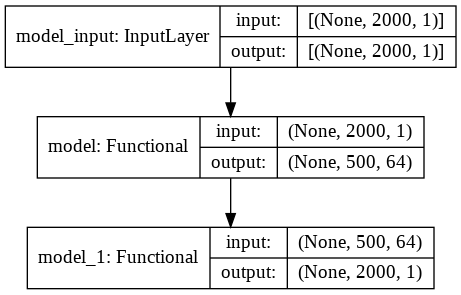

In [7]:
plot_encoder=keras.utils.plot_model(encoder,
                      to_file='{}/encoder_model_plot.png'.format(folder),
                       show_shapes=True)

plot_decoder=keras.utils.plot_model(decoder,
                      to_file='{}/decoder_model_plot.png'.format(folder),
                       show_shapes=True)




keras.utils.plot_model(autoencoder,
                      to_file='{}/autoencoder_model_plot.png'.format(folder),
                       show_shapes=True)

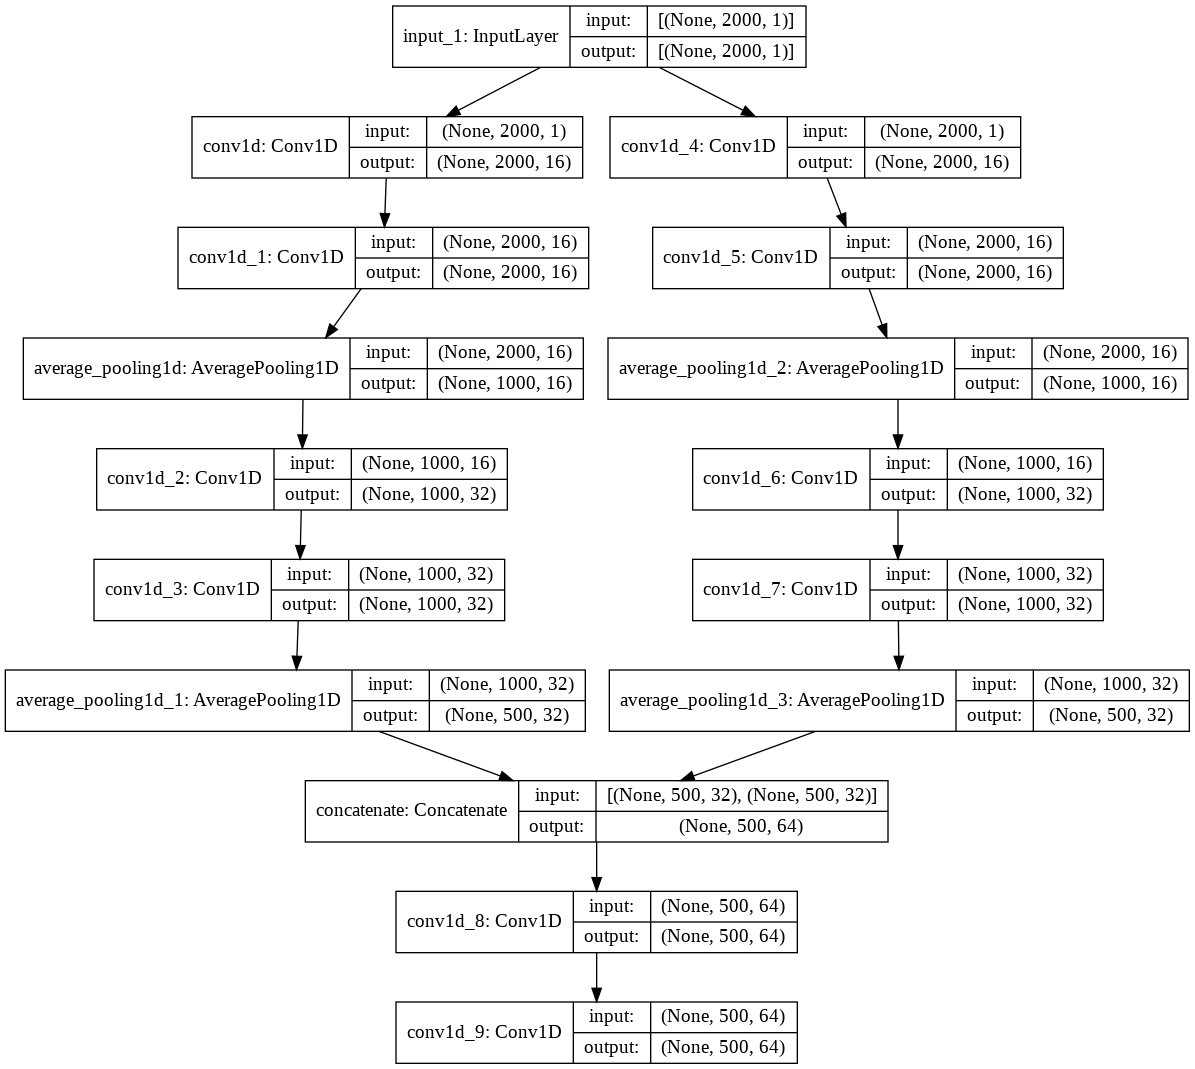

In [ ]:
plot_encoder

In [ ]:
autoencoder.compile(
    optimizer=keras.optimizers.SGD(learning_rate=.1),
    loss="binary_crossentropy",
    metrics=['accuracy']
)

class CustomSaver(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if epoch %50 == 0:  # or save after some epoch, each k-th epoch etc.
      self.model.save('{}/autoencoder_prot_epoch_{}.h5'.format(folder,epoch))
cs=CustomSaver()

logger=keras.callbacks.CSVLogger("{}/autoencoder_history.csv".format(folder), append=True)






history=autoencoder.fit(x=X_train,
                y=X_train,
                epochs=100,
                callbacks=[cs,logger],
                validation_data=(X_valid,X_valid)
)

Epoch 1/100
2978/2978 [==============================] - 134s 35ms/step - loss: 0.1086 - accuracy: 0.8224 - val_loss: 0.1020 - val_accuracy: 0.8213
Epoch 2/100
2978/2978 [==============================] - 100s 34ms/step - loss: 0.1004 - accuracy: 0.8224 - val_loss: 0.1003 - val_accuracy: 0.8213
Epoch 3/100
2978/2978 [==============================] - 100s 34ms/step - loss: 0.0995 - accuracy: 0.8224 - val_loss: 0.0999 - val_accuracy: 0.8213
Epoch 4/100
2978/2978 [==============================] - 100s 34ms/step - loss: 0.0992 - accuracy: 0.8224 - val_loss: 0.0997 - val_accuracy: 0.8213
Epoch 5/100
2978/2978 [==============================] - 100s 34ms/step - loss: 0.0990 - accuracy: 0.8224 - val_loss: 0.0995 - val_accuracy: 0.8213
Epoch 6/100
2978/2978 [==============================] - 100s 34ms/step - loss: 0.0989 - accuracy: 0.8224 - val_loss: 0.0995 - val_accuracy: 0.8213
Epoch 7/100
2978/2978 [==============================] - 100s 34ms/step - loss: 0.0988 - accuracy: 0.8224 - val_

In [ ]:
np.savez(
    '{}/datasets'.format(folder),
    train=X_train,
    valid=X_valid,
    test=X_test
)